In [1]:
# Import required modules
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

from google.colab import drive

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc

In [2]:
# Mount drive and retrieve path
drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/Parkinsons-DaTscan-master/Implementation/TRAIN_CROP/'
test_path = '/content/drive/MyDrive/Parkinsons-DaTscan-master/Implementation/TEST_CROP/'
val_path = '/content/drive/MyDrive/Parkinsons-DaTscan-master/Implementation/VAL_CROP/'

Mounted at /content/drive


In [3]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# Create train and test data loaders
batch_size = 30
num_epochs = 30

train_loader = torch.utils.data.DataLoader(ImageFolder(train_path, transform=transform), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ImageFolder(test_path, transform=transform), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(ImageFolder(val_path, transform=transform), batch_size=batch_size, shuffle=True)

In [5]:
# Load pre-trained alexNet model, Freeze pre-trained layers and Modify last layer
alexnet = models.alexnet(pretrained=True)

for param in alexnet.parameters():
    param.requires_grad = False

num_classes = 2
alexnet.classifier[-1] = torch.nn.Linear(4096, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 173MB/s]


In [6]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

accuracy_list = []
loss_list = []

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update metrics utilities
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:
            print('[Epoch %d, Batch %d] Loss: %.3f' %(epoch + 1, batch_size, running_loss / 10))
            running_loss = 0.0

    accuracy = 100 * total_correct / total_samples
    accuracy_list.append(accuracy)

    epoch_loss = running_loss / len(train_loader)
    loss_list.append(epoch_loss)

[Epoch 1, Batch 30] Loss: 0.478
[Epoch 2, Batch 30] Loss: 0.420
[Epoch 3, Batch 30] Loss: 0.309
[Epoch 4, Batch 30] Loss: 0.298
[Epoch 5, Batch 30] Loss: 0.306
[Epoch 6, Batch 30] Loss: 0.310
[Epoch 7, Batch 30] Loss: 0.329
[Epoch 8, Batch 30] Loss: 0.305
[Epoch 9, Batch 30] Loss: 0.365
[Epoch 10, Batch 30] Loss: 0.332
[Epoch 11, Batch 30] Loss: 0.246
[Epoch 12, Batch 30] Loss: 0.244
[Epoch 13, Batch 30] Loss: 0.303
[Epoch 14, Batch 30] Loss: 0.285
[Epoch 15, Batch 30] Loss: 0.291
[Epoch 16, Batch 30] Loss: 0.291
[Epoch 17, Batch 30] Loss: 0.338
[Epoch 18, Batch 30] Loss: 0.271
[Epoch 19, Batch 30] Loss: 0.279
[Epoch 20, Batch 30] Loss: 0.289
[Epoch 21, Batch 30] Loss: 0.283
[Epoch 22, Batch 30] Loss: 0.281
[Epoch 23, Batch 30] Loss: 0.258
[Epoch 24, Batch 30] Loss: 0.337
[Epoch 25, Batch 30] Loss: 0.300
[Epoch 26, Batch 30] Loss: 0.332
[Epoch 27, Batch 30] Loss: 0.306
[Epoch 28, Batch 30] Loss: 0.317
[Epoch 29, Batch 30] Loss: 0.342
[Epoch 30, Batch 30] Loss: 0.296


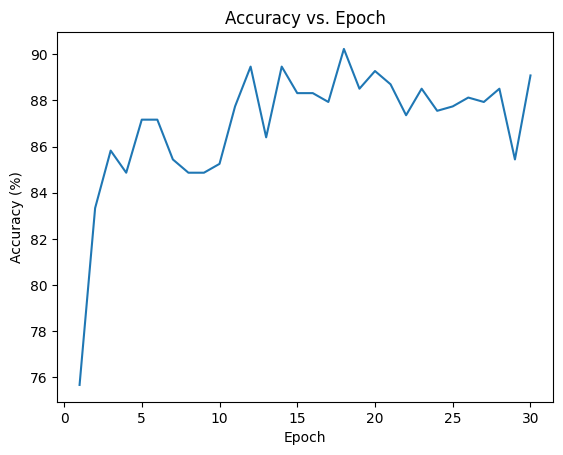

In [7]:
# Plot the accuracy versus epoch
plt.plot(range(1, num_epochs + 1), accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.show()

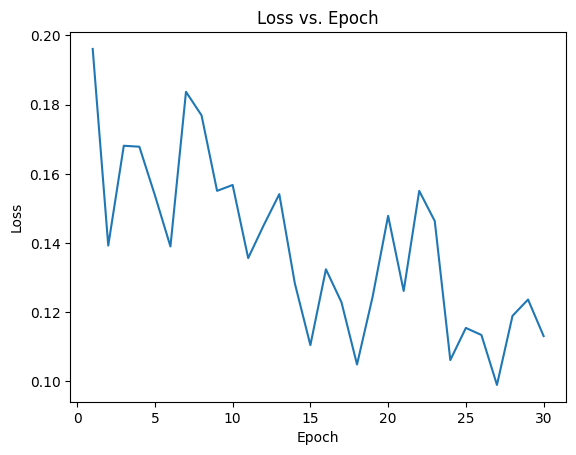

In [8]:
# Plot the loss versus epoch
plt.plot(range(1, num_epochs + 1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()

In [15]:
# Evaluate on validation set
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on validation set: %d %%' % (100 * correct / total))

Accuracy on validation set: 93 %


In [17]:
# Evaluate on test set
correct = 0
total = 0
actual = []
prediction = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        actual.extend(labels.tolist())
        prediction.extend(predicted.tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 95 %


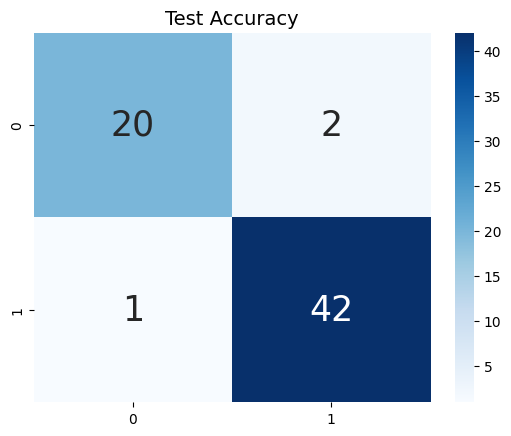

In [18]:
# Create confusion matrix on test set
confusion_mtx = confusion_matrix(actual, prediction)
ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax)
ax.set_title('Test Accuracy', size=14)
plt.show()

In [19]:
# Calculate scores
TN, FP, FN, TP = confusion_mtx.ravel()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1)

Precision: 0.9545454545454546
Recall (Sensitivity): 0.9767441860465116
Specificity: 0.9090909090909091
F1 Score: 0.9655172413793104


In [20]:
print("Classification Report:")
report = classification_report(actual, prediction, target_names=["Yes", "No"])
print(report)

Classification Report:
              precision    recall  f1-score   support

         Yes       0.95      0.91      0.93        22
          No       0.95      0.98      0.97        43

    accuracy                           0.95        65
   macro avg       0.95      0.94      0.95        65
weighted avg       0.95      0.95      0.95        65



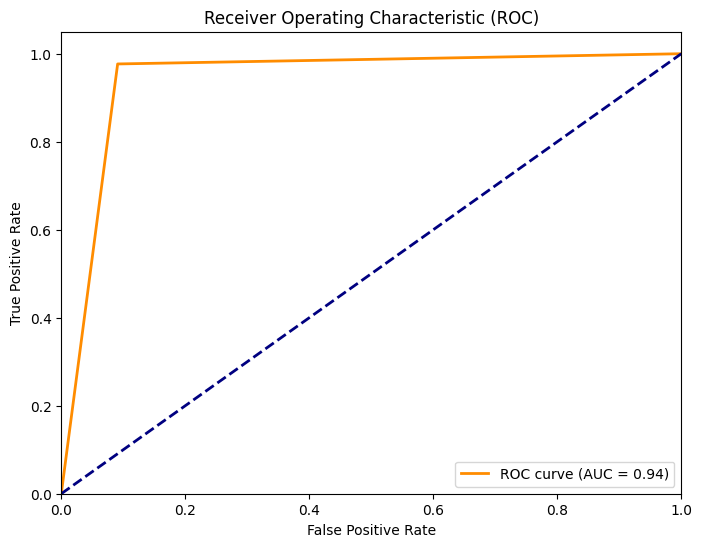

In [21]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(actual, prediction)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()